# Detecção de Fraudes em Cartões de Crédito usando Machine Learning

## Descrição do Projeto

Este projeto desenvolve um modelo de Machine Learning para detecção de transações fraudulentas em cartões de crédito. O principal desafio consiste no desbalanceamento extremo dos dados, onde fraudes são eventos raros (apenas aproximadamente 0,17% das transações).

### Objetivos

- Implementar um modelo **Random Forest** para classificação binária de transações fraudulentas
- Tratar o desbalanceamento de classes usando a técnica **SMOTE** (Synthetic Minority Over-sampling Technique)
- Otimizar as métricas de **Recall** (maximizar detecção de fraudes) e **Precisão** (minimizar falsos positivos)
- Encontrar o equilíbrio ideal entre detecção de fraudes e bloqueio indevido de transações legítimas
- Avaliar o impacto financeiro do modelo através de análise de custo-benefício

### Dataset

- **Fonte**: [Kaggle - Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)
- **Tamanho**: 284.807 transações
- **Features**: 30 variáveis (V1-V28 resultantes de transformação PCA, Time, Amount)
- **Variável alvo**: Class (0 = transação legítima, 1 = fraude)
- **Característica principal**: Dados altamente desbalanceados

---

In [1]:
!pip install -U imbalanced-learn

## 0. Configuração de Logging

Configuração do sistema de logging para monitoramento em servidor. Esta célula cria:
- Arquivo de log com rotação automática (evita crescimento infinito)
- Função `log_print()` que exibe no console E salva no log simultaneamente
- Diferentes níveis de log (INFO, WARNING, ERROR)

In [2]:
import logging
from logging.handlers import RotatingFileHandler
from datetime import datetime
import sys
import os

LOGS_DIR = "logs"
if not os.path.exists(LOGS_DIR):
    os.makedirs(LOGS_DIR)

LOG_FILENAME = os.path.join(LOGS_DIR, f'fraud_detection_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log')

logger = logging.getLogger('FraudDetection')
logger.setLevel(logging.INFO)

if logger.hasHandlers():
    logger.handlers.clear()

file_handler = RotatingFileHandler(
    LOG_FILENAME,
    maxBytes=10*1024*1024,
    backupCount=5,
    encoding='utf-8'
)
file_handler.setLevel(logging.INFO)

console_handler = logging.StreamHandler(sys.stdout)
console_handler.setLevel(logging.INFO)

formatter = logging.Formatter(
    '%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
file_handler.setFormatter(formatter)
console_handler.setFormatter(formatter)

logger.addHandler(file_handler)
logger.addHandler(console_handler)

def log_print(message, level='info'):
    level = level.lower()
    if level == 'info':
        logger.info(message)
    elif level == 'warning':
        logger.warning(message)
    elif level == 'error':
        logger.error(message)
    elif level == 'debug':
        logger.debug(message)
    else:
        logger.info(message)

def log_info(message):
    log_print(message, level='info')

def log_warning(message):
    log_print(message, level='warning')

def log_error(message):
    log_print(message, level='error')

def log_separator(char='=', length=70):
    log_print(char * length)

log_separator()
log_print(f"Sistema de logging inicializado com sucesso!")
log_print(f"Diretório de logs: {LOGS_DIR}/")
log_print(f"Arquivo de log: {LOG_FILENAME}")
log_print(f"Data/Hora de início: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
log_separator()

log_print(f"\nSistema de logging configurado!")
log_print(f"Arquivo de log: {LOG_FILENAME}\n")

2025-11-14 18:27:50 - FraudDetection - INFO - ======================================================================
2025-11-14 18:27:50 - FraudDetection - INFO - Sistema de logging inicializado com sucesso!
2025-11-14 18:27:50 - FraudDetection - INFO - Diretório de logs: logs/
2025-11-14 18:27:50 - FraudDetection - INFO - Arquivo de log: logs/fraud_detection_20251114_182750.log
2025-11-14 18:27:50 - FraudDetection - INFO - Data/Hora de início: 2025-11-14 18:27:50
2025-11-14 18:27:50 - FraudDetection - INFO - ======================================================================
2025-11-14 18:27:50 - FraudDetection - INFO - 
Sistema de logging configurado!
2025-11-14 18:27:50 - FraudDetection - INFO - Arquivo de log: logs/fraud_detection_20251114_182750.log



In [3]:
import os
from datetime import datetime

GRAFICOS_DIR = "graficos"
if not os.path.exists(GRAFICOS_DIR):
    os.makedirs(GRAFICOS_DIR)
    log_print(f"Diretório criado: {GRAFICOS_DIR}/")

grafico_counter = 0

def salvar_grafico(nome_descritivo="grafico"):
    """
    Salva o gráfico atual com um nome descritivo.
    salvar_grafico("grafico")
    Deve ser chamado ANTES de plt.show()
    """
    global grafico_counter
    grafico_counter += 1
    filename = f"{grafico_counter:02d}_{nome_descritivo}.png"
    filepath = os.path.join(GRAFICOS_DIR, filename)
    plt.savefig(filepath, dpi=300, bbox_inches="tight")
    log_print(f"Gráfico salvo: {filepath}")

log_print("Sistema de salvamento de gráficos configurado!")
log_print(f"Diretório de gráficos: {GRAFICOS_DIR}/")

2025-11-14 18:27:50 - FraudDetection - INFO - Sistema de salvamento de gráficos configurado!
2025-11-14 18:27:50 - FraudDetection - INFO - Diretório de gráficos: graficos/


## 1.1 Funções para Salvar e Carregar Modelos

Sistema de cache de modelos treinados para economizar tempo nas próximas execuções.

In [4]:
MODELOS_DIR = "modelos"
if not os.path.exists(MODELOS_DIR):
    os.makedirs(MODELOS_DIR)
    log_print(f"Diretório criado: {MODELOS_DIR}/")

def salvar_modelo(modelo, nome_arquivo, scaler=None, smote=None):
    """
    Salva o modelo treinado e objetos auxiliares.
    
    Args:
        modelo: Modelo treinado
        nome_arquivo: Nome do arquivo (sem extensão)
        scaler: StandardScaler usado (opcional)
        smote: SMOTE usado (opcional)
    """
    filepath = os.path.join(MODELOS_DIR, f"{nome_arquivo}.pkl")
    
    modelo_completo = {
        "modelo": modelo,
        "scaler": scaler,
        "smote": smote,
        "data_treinamento": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }
    
    joblib.dump(modelo_completo, filepath, compress=3)
    
    tamanho_mb = os.path.getsize(filepath) / (1024 * 1024)
    log_print(f"Modelo salvo: {filepath} ({tamanho_mb:.2f} MB)")
    
    return filepath

def carregar_modelo(nome_arquivo):
    """
    Carrega um modelo salvo anteriormente.
    
    Args:
        nome_arquivo: Nome do arquivo (sem extensão)
    
    Returns:
        Dicionário com: modelo, scaler, smote, data_treinamento
    """
    filepath = os.path.join(MODELOS_DIR, f"{nome_arquivo}.pkl")
    
    if not os.path.exists(filepath):
        log_warning(f"Arquivo não encontrado: {filepath}")
        return None
    
    try:
        modelo_completo = joblib.load(filepath)
        tamanho_mb = os.path.getsize(filepath) / (1024 * 1024)
        log_print(f"Modelo carregado: {filepath} ({tamanho_mb:.2f} MB)")
        log_print(f"   Treinado em: {modelo_completo.get('data_treinamento', 'data desconhecida')}")
        return modelo_completo
    except Exception as e:
        log_error(f"Erro ao carregar modelo: {str(e)}")
        return None

def modelo_existe(nome_arquivo):
    """
    Verifica se um modelo já foi salvo.
    """
    filepath = os.path.join(MODELOS_DIR, f"{nome_arquivo}.pkl")
    return os.path.exists(filepath)

log_print("Funções de salvar/carregar modelos configuradas!")
log_print(f"Diretório de modelos: {MODELOS_DIR}/")

2025-11-14 18:27:50 - FraudDetection - INFO - Funções de salvar/carregar modelos configuradas!
2025-11-14 18:27:50 - FraudDetection - INFO - Diretório de modelos: modelos/


## 1. Importação de Bibliotecas

Nesta seção, importamos todas as bibliotecas necessárias para análise exploratória, visualização de dados, pré-processamento e modelagem. As principais bibliotecas utilizadas incluem:

- **Pandas e NumPy**: Manipulação e operações com dados
- **Matplotlib e Seaborn**: Visualização de dados
- **Scikit-learn**: Algoritmos de machine learning, pré-processamento e avaliação
- **Imbalanced-learn**: Técnicas para tratamento de dados desbalanceados (SMOTE)

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score
)

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


import joblib
import os

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

log_print("Bibliotecas importadas com sucesso.")

2025-11-14 18:27:51 - FraudDetection - INFO - Bibliotecas importadas com sucesso.


## 2. Carregamento e Inspeção Inicial dos Dados

Carregamos o dataset e realizamos uma inspeção preliminar para compreender sua estrutura e características básicas.

In [6]:
df = pd.read_csv('creditcard.csv')

log_print(f"Dimensões do dataset: {df.shape[0]:,} linhas x {df.shape[1]} colunas")
log_print(f"\nPrimeiras linhas do dataset:")
df.head()

2025-11-14 18:27:53 - FraudDetection - INFO - Dimensões do dataset: 284,807 linhas x 31 colunas
2025-11-14 18:27:53 - FraudDetection - INFO - 
Primeiras linhas do dataset:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 3. Análise Exploratória de Dados (EDA)

A Análise Exploratória de Dados é fundamental para compreender as características do dataset, identificar padrões e validar a qualidade dos dados antes da modelagem.

### 3.1 Informações Gerais e Estatísticas Descritivas

In [7]:
log_print("INFORMAÇÕES DO DATASET")
log_print("="*70)
df.info()

log_print("\n" + "="*70)
log_print("ESTATÍSTICAS DESCRITIVAS")
log_print("="*70)
df.describe()

2025-11-14 18:27:53 - FraudDetection - INFO - INFORMAÇÕES DO DATASET
2025-11-14 18:27:53 - FraudDetection - INFO - ======================================================================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.384974e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.494498e-15,-5.620335e-16,1.149614e-16,-2.414189e-15,...,1.628620e-16,-3.576577e-16,2.618565e-16,4.473914e-15,5.109395e-16,1.686100e-15,-3.661401e-16,-1.227452e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [8]:
log_print("VERIFICAÇÃO DE QUALIDADE DOS DADOS")
log_print("="*70)
log_print("\nValores nulos por coluna:")
null_counts = df.isnull().sum()
if null_counts.sum() > 0:
    log_print(null_counts[null_counts > 0])
else:
    log_print("Nenhum valor nulo encontrado.")

log_print(f"\nNúmero de linhas duplicadas: {df.duplicated().sum()}")

inf_counts = np.isinf(df.select_dtypes(include=[np.number])).sum()
if inf_counts.sum() > 0:
    log_print("\nValores infinitos detectados:")
    log_print(inf_counts[inf_counts > 0])
else:
    log_print("\nNenhum valor infinito detectado.")

if df.isnull().sum().sum() == 0 and df.duplicated().sum() == 0 and inf_counts.sum() == 0:
    log_print("\n[OK] Dataset sem valores nulos, duplicatas ou infinitos.")
else:
    log_print("\n[ALERTA] Dataset contém valores nulos, duplicatas ou infinitos que requerem tratamento.")

2025-11-14 18:27:53 - FraudDetection - INFO - VERIFICAÇÃO DE QUALIDADE DOS DADOS
2025-11-14 18:27:53 - FraudDetection - INFO - ======================================================================
2025-11-14 18:27:53 - FraudDetection - INFO - 
Valores nulos por coluna:
2025-11-14 18:27:53 - FraudDetection - INFO - Nenhum valor nulo encontrado.
2025-11-14 18:27:54 - FraudDetection - INFO - 
Número de linhas duplicadas: 1081
2025-11-14 18:27:54 - FraudDetection - INFO - 
Nenhum valor infinito detectado.
2025-11-14 18:27:54 - FraudDetection - INFO - 
[ALERTA] Dataset contém valores nulos, duplicatas ou infinitos que requerem tratamento.


### 3.2 Análise do Desbalanceamento das Classes

O desbalanceamento de classes é a característica mais crítica deste dataset. Em problemas de detecção de fraude, a classe positiva (fraude) representa uma porcentagem muito pequena do total de transações. Este desbalanceamento pode causar viés no modelo, que tenderá a favorecer a classe majoritária.

**Impacto do Desbalanceamento:**
- Modelos tendem a classificar tudo como classe majoritária
- Métricas como acurácia tornam-se enganosas
- Necessidade de técnicas especiais de balanceamento (SMOTE)
- Importância de métricas alternativas (Recall, Precisão, F1-Score)

In [9]:
class_counts = df['Class'].value_counts()
class_percentages = df['Class'].value_counts(normalize=True) * 100

log_print("DISTRIBUIÇÃO DAS CLASSES")
log_print("="*70)
log_print(f"Classe 0 (Transações Legítimas): {class_counts[0]:,} ({class_percentages[0]:.4f}%)")
log_print(f"Classe 1 (Fraudes):              {class_counts[1]:,} ({class_percentages[1]:.4f}%)")
log_print(f"\nRazão de Desbalanceamento: 1:{class_counts[0]/class_counts[1]:.0f}")
log_print(f"Interpretação: Para cada transação fraudulenta, existem aproximadamente {class_counts[0]/class_counts[1]:.0f} transações legítimas")

2025-11-14 18:27:54 - FraudDetection - INFO - DISTRIBUIÇÃO DAS CLASSES
2025-11-14 18:27:54 - FraudDetection - INFO - ======================================================================
2025-11-14 18:27:54 - FraudDetection - INFO - Classe 0 (Transações Legítimas): 284,315 (99.8273%)
2025-11-14 18:27:54 - FraudDetection - INFO - Classe 1 (Fraudes):              492 (0.1727%)
2025-11-14 18:27:54 - FraudDetection - INFO - 
Razão de Desbalanceamento: 1:578
2025-11-14 18:27:54 - FraudDetection - INFO - Interpretação: Para cada transação fraudulenta, existem aproximadamente 578 transações legítimas


2025-11-14 18:27:55 - FraudDetection - INFO - Gráfico salvo: graficos/01_roc_curve.png


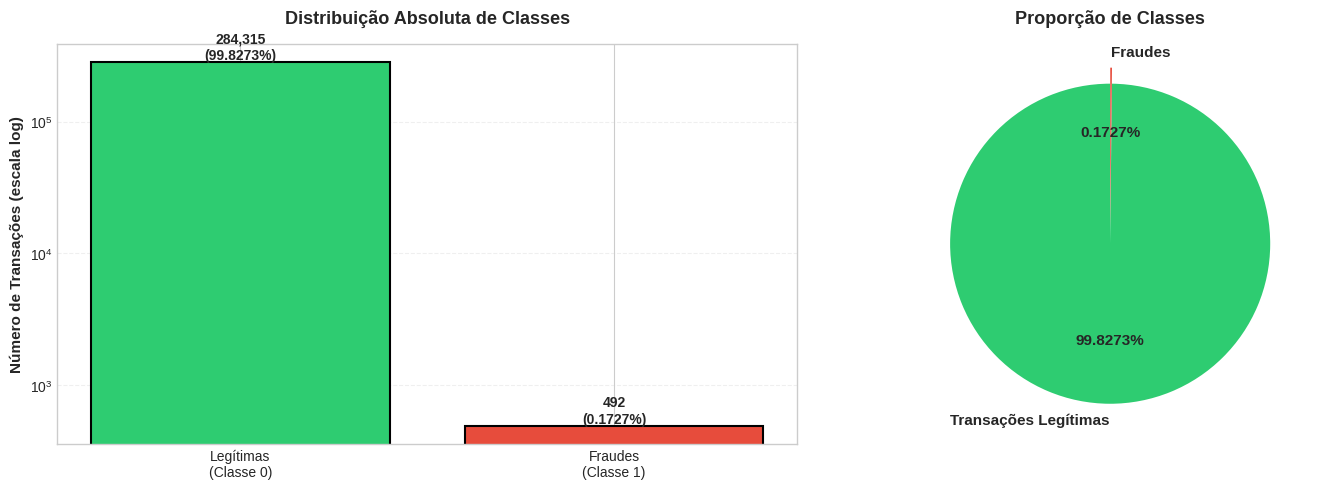

2025-11-14 18:27:55 - FraudDetection - INFO - 
IMPLICAÇÕES DO DESBALANCEAMENTO:
2025-11-14 18:27:55 - FraudDetection - INFO - ======================================================================
2025-11-14 18:27:55 - FraudDetection - INFO - 1. Acurácia não é uma métrica adequada (modelo pode ter 99.8% de acurácia
2025-11-14 18:27:55 - FraudDetection - INFO -    simplesmente classificando tudo como classe majoritária)
2025-11-14 18:27:55 - FraudDetection - INFO - 2. Necessidade de técnicas de balanceamento (SMOTE será aplicado)
2025-11-14 18:27:55 - FraudDetection - INFO - 3. Métricas relevantes: Recall, Precisão, F1-Score, AUC-ROC
2025-11-14 18:27:55 - FraudDetection - INFO - 4. Validação cruzada estratificada é essencial


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].bar(['Legítimas\n(Classe 0)', 'Fraudes\n(Classe 1)'],
            class_counts.values,
            color=['#2ecc71', '#e74c3c'],
            edgecolor='black',
            linewidth=1.5)
axes[0].set_ylabel('Número de Transações (escala log)', fontsize=11, fontweight='bold')
axes[0].set_title('Distribuição Absoluta de Classes', fontsize=13, fontweight='bold', pad=15)
axes[0].set_yscale('log')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v, f'{v:,}\n({class_percentages.values[i]:.4f}%)',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

colors = ['#2ecc71', '#e74c3c']
explode = (0, 0.1)
wedges, texts, autotexts = axes[1].pie(class_counts.values,
                                        labels=['Transações Legítimas', 'Fraudes'],
                                        autopct='%1.4f%%',
                                        colors=colors,
                                        explode=explode,
                                        startangle=90,
                                        textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Proporção de Classes', fontsize=13, fontweight='bold', pad=15)

plt.tight_layout()
salvar_grafico("roc_curve")
plt.show()

log_print("\nIMPLICAÇÕES DO DESBALANCEAMENTO:")
log_print("="*70)
log_print("1. Acurácia não é uma métrica adequada (modelo pode ter 99.8% de acurácia")
log_print("   simplesmente classificando tudo como classe majoritária)")
log_print("2. Necessidade de técnicas de balanceamento (SMOTE será aplicado)")
log_print("3. Métricas relevantes: Recall, Precisão, F1-Score, AUC-ROC")
log_print("4. Validação cruzada estratificada é essencial")

### 3.3 Análise das Features Numéricas

As features `Time` e `Amount` são as únicas que não foram transformadas por PCA e, portanto, mantêm sua interpretação original:

- **Time**: Segundos decorridos entre cada transação e a primeira transação no dataset
- **Amount**: Valor monetário da transação

Analisaremos a distribuição destas variáveis por classe para identificar possíveis padrões discriminatórios.

In [11]:
log_print("ANÁLISE DA FEATURE 'AMOUNT' POR CLASSE")
log_print("="*70)
amount_stats = df.groupby('Class')['Amount'].describe()
log_print(amount_stats)

log_print("\nOBSERVAÇÕES:")
legit_mean = amount_stats.loc[0, 'mean']
fraud_mean = amount_stats.loc[1, 'mean']
log_print(f"- Valor médio de transações legítimas: ${legit_mean:.2f}")
log_print(f"- Valor médio de fraudes: ${fraud_mean:.2f}")
log_print(f"- Diferença: ${abs(legit_mean - fraud_mean):.2f}")

2025-11-14 18:27:55 - FraudDetection - INFO - ANÁLISE DA FEATURE 'AMOUNT' POR CLASSE
2025-11-14 18:27:55 - FraudDetection - INFO - ======================================================================
2025-11-14 18:27:55 - FraudDetection - INFO -           count        mean         std  min   25%    50%     75%       max
Class                                                                      
0      284315.0   88.291022  250.105092  0.0  5.65  22.00   77.05  25691.16
1         492.0  122.211321  256.683288  0.0  1.00   9.25  105.89   2125.87
2025-11-14 18:27:55 - FraudDetection - INFO - 
OBSERVAÇÕES:
2025-11-14 18:27:55 - FraudDetection - INFO - - Valor médio de transações legítimas: $88.29
2025-11-14 18:27:55 - FraudDetection - INFO - - Valor médio de fraudes: $122.21
2025-11-14 18:27:55 - FraudDetection - INFO - - Diferença: $33.92


2025-11-14 18:27:56 - FraudDetection - INFO - Gráfico salvo: graficos/02_boxplot.png


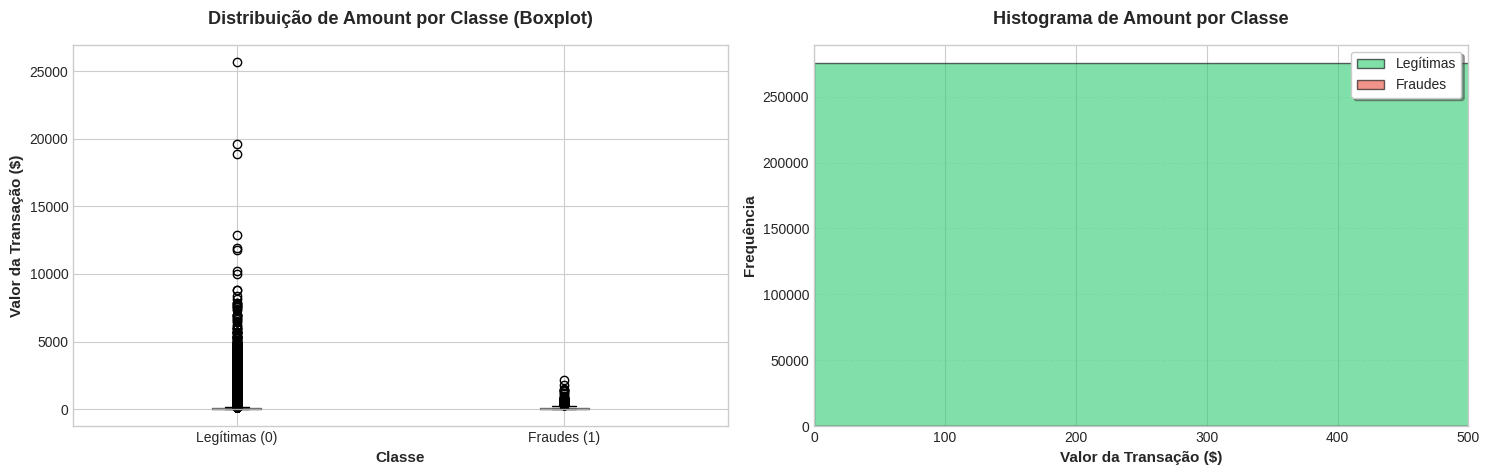

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

df.boxplot(column='Amount', by='Class', ax=axes[0], patch_artist=True)
axes[0].set_title('Distribuição de Amount por Classe (Boxplot)',
                  fontsize=13, fontweight='bold', pad=15)
axes[0].set_xlabel('Classe', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Valor da Transação ($)', fontsize=11, fontweight='bold')
axes[0].get_figure().suptitle('')
plt.sca(axes[0])
plt.xticks([1, 2], ['Legítimas (0)', 'Fraudes (1)'])

axes[1].hist(df[df['Class'] == 0]['Amount'], bins=50, alpha=0.6,
            label='Legítimas', color='#2ecc71', edgecolor='black')
axes[1].hist(df[df['Class'] == 1]['Amount'], bins=50, alpha=0.6,
            label='Fraudes', color='#e74c3c', edgecolor='black')
axes[1].set_xlabel('Valor da Transação ($)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Frequência', fontsize=11, fontweight='bold')
axes[1].set_title('Histograma de Amount por Classe', fontsize=13, fontweight='bold', pad=15)
axes[1].legend(loc='upper right', frameon=True, shadow=True)
axes[1].set_xlim([0, 500])
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
salvar_grafico("boxplot")
plt.show()

2025-11-14 18:27:57 - FraudDetection - INFO - Gráfico salvo: graficos/03_histogram.png


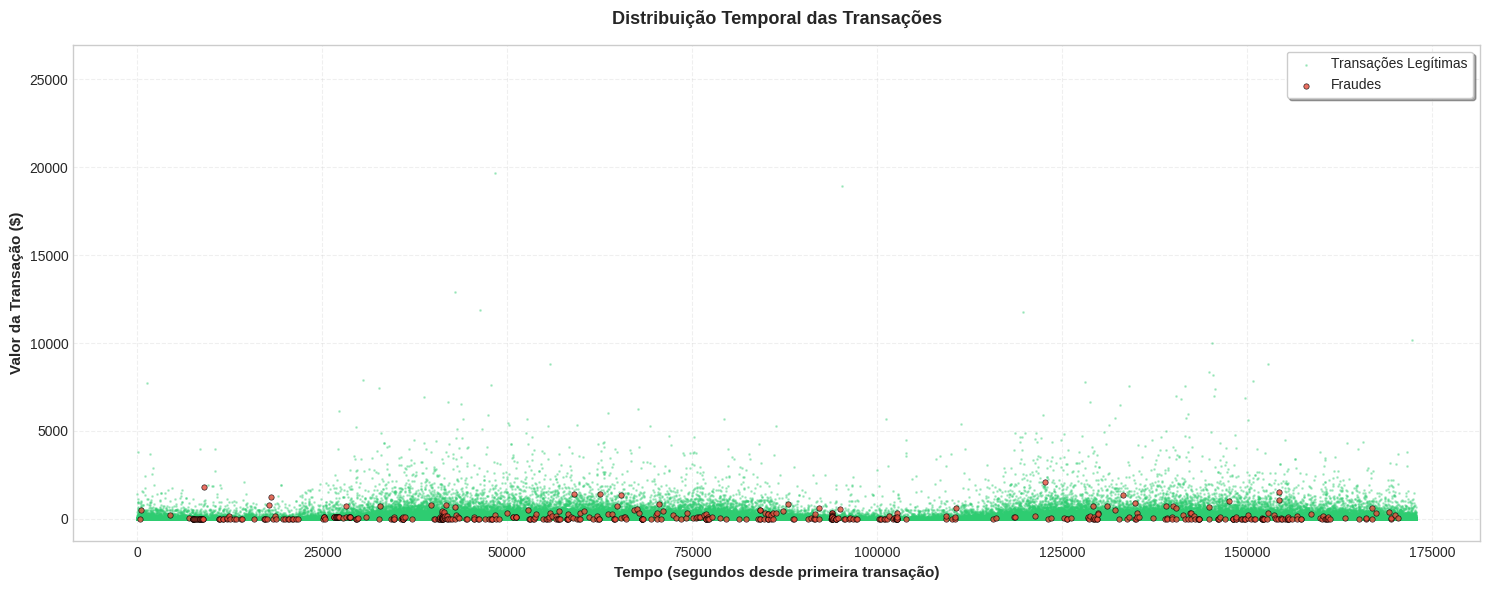

2025-11-14 18:27:57 - FraudDetection - INFO - INTERPRETAÇÃO:
2025-11-14 18:27:57 - FraudDetection - INFO - - Fraudes destacadas em vermelho mostram padrões temporais específicos
2025-11-14 18:27:57 - FraudDetection - INFO - - A distribuição temporal pode ser uma feature relevante para detecção


In [13]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.scatter(df[df['Class'] == 0]['Time'],
          df[df['Class'] == 0]['Amount'],
          alpha=0.3, label='Transações Legítimas',
          c='#2ecc71', s=1, rasterized=True)
ax.scatter(df[df['Class'] == 1]['Time'],
          df[df['Class'] == 1]['Amount'],
          alpha=0.8, label='Fraudes',
          c='#e74c3c', s=15, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Tempo (segundos desde primeira transação)', fontsize=11, fontweight='bold')
ax.set_ylabel('Valor da Transação ($)', fontsize=11, fontweight='bold')
ax.set_title('Distribuição Temporal das Transações', fontsize=13, fontweight='bold', pad=15)
ax.legend(loc='upper right', frameon=True, shadow=True)
ax.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
salvar_grafico("histogram")
plt.show()

log_print("INTERPRETAÇÃO:")
log_print("- Fraudes destacadas em vermelho mostram padrões temporais específicos")
log_print("- A distribuição temporal pode ser uma feature relevante para detecção")

### 3.4 Análise de Correlação com a Variável Alvo

A matriz de correlação nos permite identificar quais features têm maior associação linear com a variável alvo (Class). Features com correlação absoluta mais alta tendem a ser mais importantes para a classificação.

In [14]:
correlation_with_target = df.corr()['Class'].sort_values(ascending=False)

log_print("CORRELAÇÃO DAS FEATURES COM A VARIÁVEL ALVO (CLASS)")
log_print("="*70)
log_print("\nTop 10 Features com Correlação Positiva:")
log_print(correlation_with_target.head(11))

log_print("\nTop 10 Features com Correlação Negativa:")
log_print(correlation_with_target.tail(10))

log_print("\nINTERPRETAÇÃO:")
log_print("- Correlação positiva: aumento da feature associado ao aumento da probabilidade de fraude")
log_print("- Correlação negativa: aumento da feature associado à diminuição da probabilidade de fraude")
log_print("- Valores próximos a 0 indicam baixa correlação linear")

2025-11-14 18:27:58 - FraudDetection - INFO - CORRELAÇÃO DAS FEATURES COM A VARIÁVEL ALVO (CLASS)
2025-11-14 18:27:58 - FraudDetection - INFO - ======================================================================
2025-11-14 18:27:58 - FraudDetection - INFO - 
Top 10 Features com Correlação Positiva:
2025-11-14 18:27:58 - FraudDetection - INFO - Class     1.000000
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
Name: Class, dtype: float64
2025-11-14 18:27:58 - FraudDetection - INFO - 
Top 10 Features com Correlação Negativa:
2025-11-14 18:27:58 - FraudDetection - INFO - V9    -0.097733
V1    -0.101347
V18   -0.111485
V7    -0.187257
V3    -0.192961
V16   -0.196539
V10   -0.216883
V12   -0.260593
V14   -0.302544
V17   -0.326481
Name: Class, dtype: float64
2025-11-14 18:27:58 - FraudDetection - INFO - 
INTERPRETAÇÃO:
2025-11-14 18:27:58 - FraudDet

2025-11-14 18:27:59 - FraudDetection - INFO - Gráfico salvo: graficos/04_correlation_heatmap.png


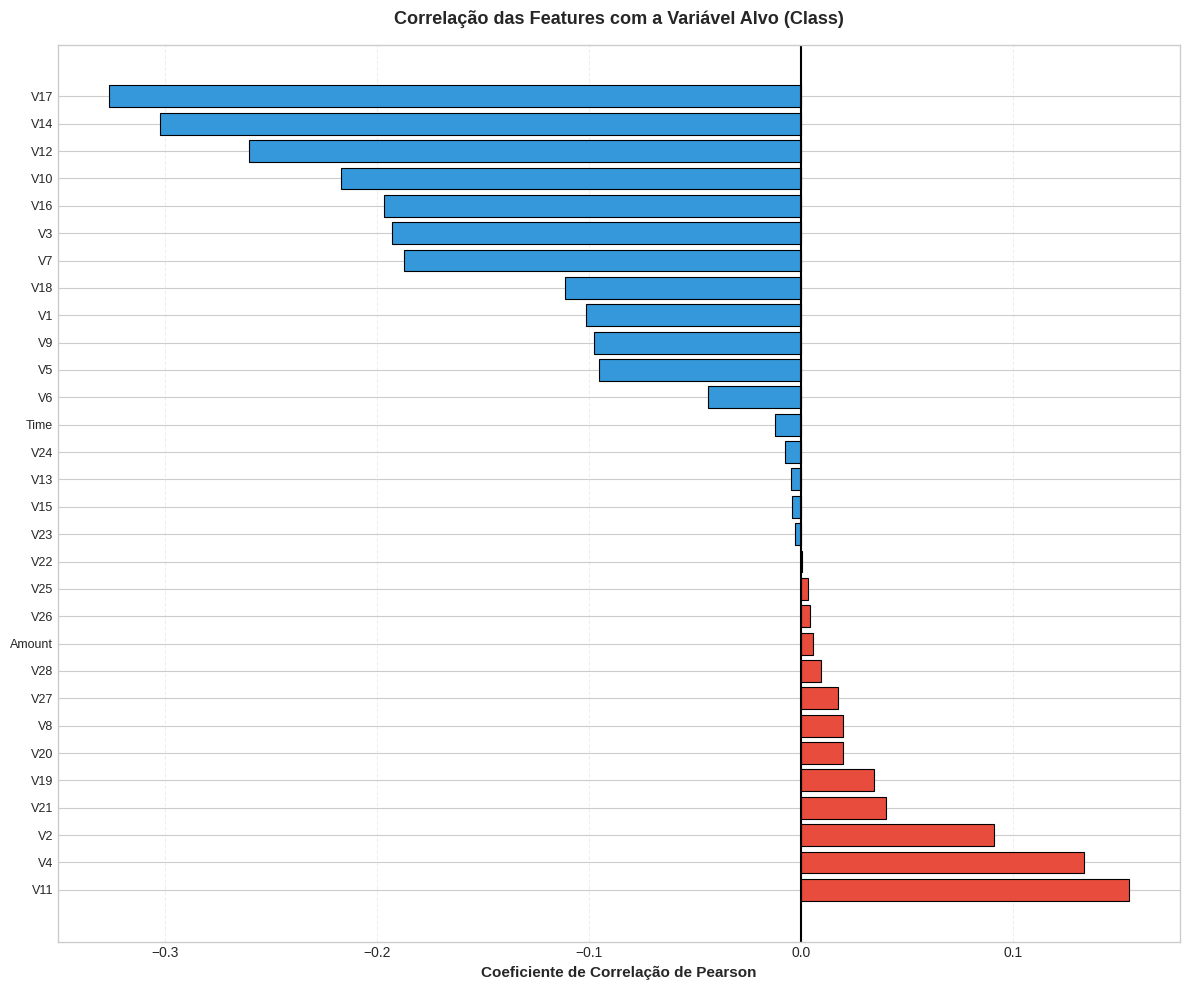

In [15]:
plt.figure(figsize=(12, 10))

correlation_with_target_filtered = correlation_with_target[1:]
colors = ['#e74c3c' if x > 0 else '#3498db' for x in correlation_with_target_filtered]

plt.barh(range(len(correlation_with_target_filtered)),
        correlation_with_target_filtered.values,
        color=colors,
        edgecolor='black',
        linewidth=0.8)
plt.yticks(range(len(correlation_with_target_filtered)),
          correlation_with_target_filtered.index,
          fontsize=9)
plt.xlabel('Coeficiente de Correlação de Pearson', fontsize=11, fontweight='bold')
plt.title('Correlação das Features com a Variável Alvo (Class)',
         fontsize=13, fontweight='bold', pad=15)
plt.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
salvar_grafico("correlation_heatmap")
plt.show()

## 4. Preparação dos Dados

### 4.1 Separação de Features e Variável Alvo

Separamos o dataset em matriz de features (X) e vetor de labels (y) para o processo de modelagem.

In [16]:
X = df.drop('Class', axis=1)
y = df['Class']

log_print("SEPARAÇÃO DE DADOS")
log_print("="*70)
log_print(f"Dimensões da matriz de features (X): {X.shape}")
log_print(f"Dimensões do vetor de labels (y): {y.shape}")
log_print(f"\nColunas das features:\n{list(X.columns)}")

2025-11-14 18:27:59 - FraudDetection - INFO - SEPARAÇÃO DE DADOS
2025-11-14 18:27:59 - FraudDetection - INFO - ======================================================================
2025-11-14 18:27:59 - FraudDetection - INFO - Dimensões da matriz de features (X): (284807, 30)
2025-11-14 18:27:59 - FraudDetection - INFO - Dimensões do vetor de labels (y): (284807,)
2025-11-14 18:27:59 - FraudDetection - INFO - 
Colunas das features:
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


### 4.2 Verificação e Limpeza de Dados

Antes de dividir os dados, verificamos a presença de valores ausentes (NaN) que podem comprometer o treinamento do modelo.

In [17]:
log_print("VERIFICAÇÃO FINAL ANTES DA DIVISÃO DOS DADOS")
log_print("="*70)
log_print(f"\nValores NaN em X: {X.isnull().sum().sum()}")
log_print(f"Valores NaN em y: {y.isnull().sum()}")

inf_mask_X = np.isinf(X.select_dtypes(include=[np.number])).any(axis=1)
log_print(f"Valores infinitos em X: {inf_mask_X.sum()}")

valid_mask = ~(X.isnull().any(axis=1) | y.isnull() | inf_mask_X)

if (~valid_mask).sum() > 0:
    log_print(f"\n[ALERTA] {(~valid_mask).sum()} linhas com valores inválidos detectadas.")
    log_print("Removendo linhas com valores ausentes ou infinitos...")
    X = X[valid_mask]
    y = y[valid_mask]
    log_print(f"Dataset resultante: {X.shape[0]:,} linhas")
else:
    log_print("\n[OK] Nenhum valor inválido detectado.")

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

log_print(f"\nDimensões finais: X = {X.shape}, y = {y.shape}")

2025-11-14 18:27:59 - FraudDetection - INFO - VERIFICAÇÃO FINAL ANTES DA DIVISÃO DOS DADOS
2025-11-14 18:27:59 - FraudDetection - INFO - ======================================================================
2025-11-14 18:27:59 - FraudDetection - INFO - 
Valores NaN em X: 0
2025-11-14 18:27:59 - FraudDetection - INFO - Valores NaN em y: 0
2025-11-14 18:27:59 - FraudDetection - INFO - Valores infinitos em X: 0
2025-11-14 18:27:59 - FraudDetection - INFO - 
[OK] Nenhum valor inválido detectado.
2025-11-14 18:27:59 - FraudDetection - INFO - 
Dimensões finais: X = (284807, 30), y = (284807,)


### 4.3 Divisão em Conjuntos de Treino e Teste

Realizamos a divisão estratificada dos dados em conjuntos de treino (80%) e teste (20%). A estratificação é crucial para manter a proporção de classes em ambos os conjuntos, especialmente importante em datasets desbalanceados.

**Justificativa da proporção 80-20:**
- Proporciona dados suficientes para treinamento
- Mantém conjunto de teste representativo
- É uma prática padrão em problemas de classificação

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

log_print("DIVISÃO DOS DADOS")
log_print("="*70)
log_print(f"\nConjunto de Treino: {X_train.shape[0]:,} amostras ({X_train.shape[0]/len(X)*100:.1f}%)")
log_print(f"Conjunto de Teste:  {X_test.shape[0]:,} amostras ({X_test.shape[0]/len(X)*100:.1f}%)")

log_print("\nDISTRIBUIÇÃO DE CLASSES NO CONJUNTO DE TREINO:")
log_print(y_train.value_counts())
log_print(f"Proporção de fraudes: {y_train.value_counts()[1]/len(y_train)*100:.4f}%")

log_print("\nDISTRIBUIÇÃO DE CLASSES NO CONJUNTO DE TESTE:")
log_print(y_test.value_counts())
log_print(f"Proporção de fraudes: {y_test.value_counts()[1]/len(y_test)*100:.4f}%")

log_print("\n[OK] Estratificação bem-sucedida: proporções mantidas em ambos os conjuntos.")

2025-11-14 18:27:59 - FraudDetection - INFO - DIVISÃO DOS DADOS
2025-11-14 18:27:59 - FraudDetection - INFO - ======================================================================
2025-11-14 18:27:59 - FraudDetection - INFO - 
Conjunto de Treino: 227,845 amostras (80.0%)
2025-11-14 18:27:59 - FraudDetection - INFO - Conjunto de Teste:  56,962 amostras (20.0%)
2025-11-14 18:27:59 - FraudDetection - INFO - 
DISTRIBUIÇÃO DE CLASSES NO CONJUNTO DE TREINO:
2025-11-14 18:27:59 - FraudDetection - INFO - Class
0    227451
1       394
Name: count, dtype: int64
2025-11-14 18:27:59 - FraudDetection - INFO - Proporção de fraudes: 0.1729%
2025-11-14 18:27:59 - FraudDetection - INFO - 
DISTRIBUIÇÃO DE CLASSES NO CONJUNTO DE TESTE:
2025-11-14 18:27:59 - FraudDetection - INFO - Class
0    56864
1       98
Name: count, dtype: int64
2025-11-14 18:27:59 - FraudDetection - INFO - Proporção de fraudes: 0.1720%
2025-11-14 18:27:59 - FraudDetection - INFO - 
[OK] Estratificação bem-sucedida: proporções mant

### 4.4 Normalização das Features

Aplicamos normalização (padronização Z-score) nas features `Time` e `Amount`, pois estas possuem escalas diferentes das features transformadas por PCA (V1-V28), que já estão normalizadas.

**Nota importante**: O scaler é ajustado (fitted) apenas no conjunto de treino e depois aplicado ao conjunto de teste para evitar data leakage.

In [19]:
scaler = StandardScaler()

cols_to_scale = ['Time', 'Amount']

log_print("NORMALIZAÇÃO DE FEATURES")
log_print("="*70)
log_print(f"\nFeatures a serem normalizadas: {cols_to_scale}")
log_print("\nEstatísticas ANTES da normalização:")
log_print(X_train[cols_to_scale].describe())

X_train = X_train.copy()
X_test = X_test.copy()

X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

log_print("\nEstatísticas APÓS a normalização (conjunto de treino):")
log_print(X_train[cols_to_scale].describe())

log_print("\n[OK] Normalização concluída com sucesso.")
log_print("     Média aproximadamente 0 e Desvio Padrão aproximadamente 1 para as features normalizadas.")

2025-11-14 18:27:59 - FraudDetection - INFO - NORMALIZAÇÃO DE FEATURES
2025-11-14 18:27:59 - FraudDetection - INFO - ======================================================================
2025-11-14 18:27:59 - FraudDetection - INFO - 
Features a serem normalizadas: ['Time', 'Amount']
2025-11-14 18:27:59 - FraudDetection - INFO - 
Estatísticas ANTES da normalização:
2025-11-14 18:27:59 - FraudDetection - INFO -                 Time         Amount
count  227845.000000  227845.000000
mean    94885.093704      88.176298
std     47488.415034     250.722602
min         0.000000       0.000000
25%     54228.000000       5.640000
50%     84805.000000      22.000000
75%    139364.000000      77.490000
max    172792.000000   25691.160000
2025-11-14 18:27:59 - FraudDetection - INFO - 
Estatísticas APÓS a normalização (conjunto de treino):
2025-11-14 18:27:59 - FraudDetection - INFO -                Time        Amount
count  2.278450e+05  2.278450e+05
mean  -1.409578e-16  3.742243e-17
std    1.000

## 5. Aplicação do SMOTE (Synthetic Minority Over-sampling Technique)

### Fundamentação Teórica

**SMOTE** é uma técnica de oversampling que gera exemplos sintéticos da classe minoritária ao invés de simplesmente duplicar exemplos existentes, evitando overfitting.

**Algoritmo:**
1. Para cada amostra $x_i$ da classe minoritária:
   - Identifica seus $k$ vizinhos mais próximos da mesma classe
   - Seleciona aleatoriamente um vizinho $x_{zi}$
   - Cria nova amostra sintética: $x_{novo} = x_i + \lambda \times (x_{zi} - x_i)$, onde $\lambda \in [0,1]$

**Vantagens:**
- Aumenta a representatividade da classe minoritária
- Cria exemplos plausíveis (interpolação no espaço de features)
- Reduz overfitting comparado à simples replicação

**CRÍTICO**: SMOTE é aplicado **APENAS** no conjunto de treino para prevenir data leakage e garantir avaliação não enviesada.

In [20]:
log_print("APLICAÇÃO DO SMOTE")
log_print("="*70)

log_print("\nDistribuição de classes ANTES do SMOTE (Conjunto de Treino):")
log_print(f"Classe 0 (Legítimas): {(y_train == 0).sum():,}")
log_print(f"Classe 1 (Fraudes):   {(y_train == 1).sum():,}")
log_print(f"Razão: 1:{(y_train == 0).sum()/(y_train == 1).sum():.0f}")

log_print("\nAplicando SMOTE com k_neighbors=5...")
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

log_print("\nDistribuição de classes APÓS o SMOTE (Conjunto de Treino):")
log_print(f"Classe 0 (Legítimas): {(y_train_resampled == 0).sum():,}")
log_print(f"Classe 1 (Fraudes):   {(y_train_resampled == 1).sum():,}")
log_print(f"Razão: 1:1 (Balanceado)")

synthetic_samples = (y_train_resampled == 1).sum() - (y_train == 1).sum()
log_print(f"\nAmostras sintéticas criadas: {synthetic_samples:,}")
log_print(f"Total de amostras após SMOTE: {len(y_train_resampled):,}")
log_print("\n[OK] SMOTE aplicado com sucesso. Classes balanceadas no conjunto de treino.")

2025-11-14 18:27:59 - FraudDetection - INFO - APLICAÇÃO DO SMOTE
2025-11-14 18:27:59 - FraudDetection - INFO - ======================================================================
2025-11-14 18:27:59 - FraudDetection - INFO - 
Distribuição de classes ANTES do SMOTE (Conjunto de Treino):
2025-11-14 18:27:59 - FraudDetection - INFO - Classe 0 (Legítimas): 227,451
2025-11-14 18:27:59 - FraudDetection - INFO - Classe 1 (Fraudes):   394
2025-11-14 18:27:59 - FraudDetection - INFO - Razão: 1:577
2025-11-14 18:27:59 - FraudDetection - INFO - 
Aplicando SMOTE com k_neighbors=5...
2025-11-14 18:27:59 - FraudDetection - INFO - 
Distribuição de classes APÓS o SMOTE (Conjunto de Treino):
2025-11-14 18:27:59 - FraudDetection - INFO - Classe 0 (Legítimas): 227,451
2025-11-14 18:27:59 - FraudDetection - INFO - Classe 1 (Fraudes):   227,451
2025-11-14 18:27:59 - FraudDetection - INFO - Razão: 1:1 (Balanceado)
2025-11-14 18:27:59 - FraudDetection - INFO - 
Amostras sintéticas criadas: 227,057
2025-11

2025-11-14 18:28:00 - FraudDetection - INFO - Gráfico salvo: graficos/05_histogram.png


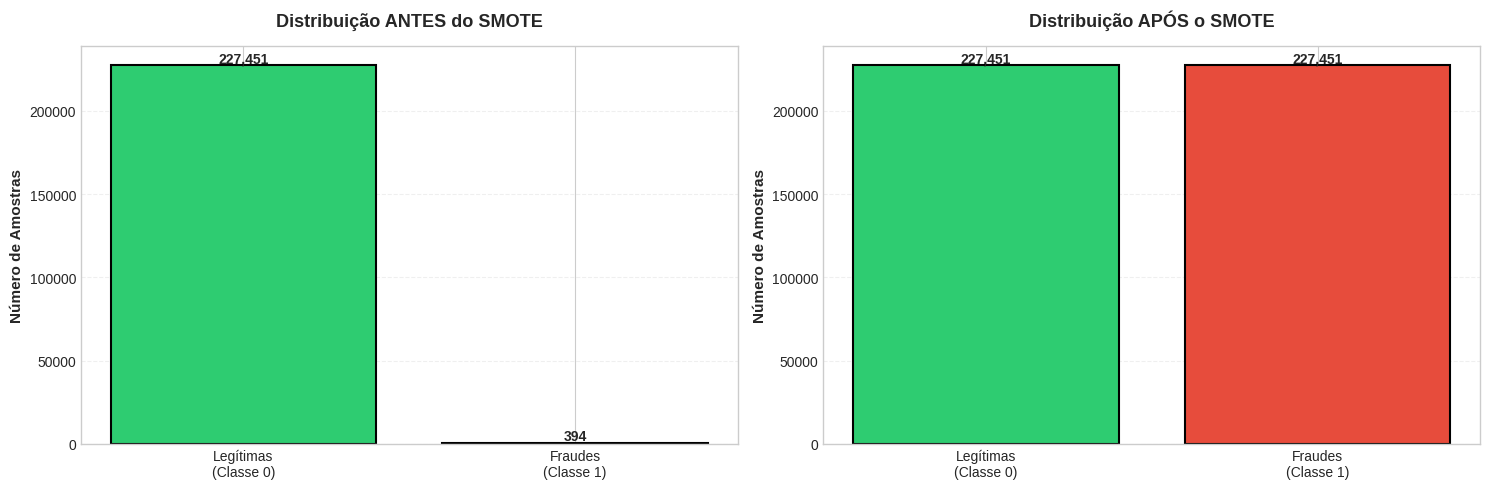

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

before_counts = y_train.value_counts()
axes[0].bar(['Legítimas\n(Classe 0)', 'Fraudes\n(Classe 1)'],
           before_counts.values,
           color=['#2ecc71', '#e74c3c'],
           edgecolor='black',
           linewidth=1.5)
axes[0].set_title('Distribuição ANTES do SMOTE', fontsize=13, fontweight='bold', pad=15)
axes[0].set_ylabel('Número de Amostras', fontsize=11, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(before_counts.values):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

after_counts = pd.Series(y_train_resampled).value_counts()
axes[1].bar(['Legítimas\n(Classe 0)', 'Fraudes\n(Classe 1)'],
           after_counts.values,
           color=['#2ecc71', '#e74c3c'],
           edgecolor='black',
           linewidth=1.5)
axes[1].set_title('Distribuição APÓS o SMOTE', fontsize=13, fontweight='bold', pad=15)
axes[1].set_ylabel('Número de Amostras', fontsize=11, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(after_counts.values):
    axes[1].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
salvar_grafico("histogram")
plt.show()

## 6. Modelagem com Random Forest

### Fundamentação Teórica

**Random Forest** é um algoritmo de ensemble que combina múltiplas árvores de decisão para produzir predições mais robustas e precisas através de votação majoritária (classificação) ou média (regressão).

**Características principais:**
- **Bagging**: Cada árvore é treinada em um subset aleatório dos dados (bootstrap sample)
- **Feature randomness**: Em cada divisão, apenas um subset aleatório de features é considerado
- **Ensemble**: A predição final é a agregação das predições individuais

**Vantagens para detecção de fraude:**
- Robusto a outliers e dados ruidosos
- Reduz overfitting através do ensemble
- Lida bem com dados desbalanceados (com ajuste de class_weight)
- Fornece medida de importância das features
- Não requer normalização das features (embora já aplicada)
- Captura interações não-lineares complexas

### 6.1 Modelo Baseline

Estabelecemos um modelo baseline com hiperparâmetros padrão para servir como linha de base para comparação.

In [ ]:
log_print("TREINAMENTO DO MODELO BASELINE")
log_print("="*70)
log_print("\nInicializando Random Forest com configurações padrão...")

rf_baseline = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

log_print("\nTreinando modelo...")
rf_baseline.fit(X_train_resampled, y_train_resampled)

log_print("\n[OK] Modelo baseline treinado com sucesso.")
log_print(f"     Número de árvores: {rf_baseline.n_estimators}")
log_print(f"     Número de features: {rf_baseline.n_features_in_}")

log_print("\nSalvando modelo baseline...")
salvar_modelo(rf_baseline, "modelo_baseline", scaler=scaler, smote=smote)

2025-11-14 18:28:00 - FraudDetection - INFO - TREINAMENTO DO MODELO BASELINE
2025-11-14 18:28:00 - FraudDetection - INFO - ======================================================================
2025-11-14 18:28:00 - FraudDetection - INFO - 
Inicializando Random Forest com configurações padrão...
2025-11-14 18:28:00 - FraudDetection - INFO - 
Treinando modelo...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   56.8s


### 6.2 Avaliação do Modelo Baseline

**Métricas de Avaliação:**

- **Acurácia**: Proporção de predições corretas (pode ser enganosa em dados desbalanceados)
- **Precisão**: $\frac{TP}{TP + FP}$ - Proporção de fraudes detectadas que são realmente fraudes
- **Recall (Sensibilidade)**: $\frac{TP}{TP + FN}$ - Proporção de fraudes reais que foram detectadas
- **F1-Score**: $2 \times \frac{Precisão \times Recall}{Precisão + Recall}$ - Média harmônica entre Precisão e Recall
- **ROC-AUC**: Área sob a curva ROC - Mede a capacidade de discriminação do modelo

In [ ]:
y_pred_baseline = rf_baseline.predict(X_test)
y_pred_proba_baseline = rf_baseline.predict_proba(X_test)[:, 1]

log_print("AVALIAÇÃO DO MODELO BASELINE")
log_print("="*70)

log_print("\nMÉTRICAS DE DESEMPENHO:")
log_print(f"  Acurácia:  {accuracy_score(y_test, y_pred_baseline):.4f}")
log_print(f"  Precisão:  {precision_score(y_test, y_pred_baseline):.4f}")
log_print(f"  Recall:    {recall_score(y_test, y_pred_baseline):.4f}")
log_print(f"  F1-Score:  {f1_score(y_test, y_pred_baseline):.4f}")
log_print(f"  ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_baseline):.4f}")

log_print("\n" + "="*70)
log_print("RELATÓRIO DE CLASSIFICAÇÃO DETALHADO")
log_print("="*70)
log_print(classification_report(y_test, y_pred_baseline,
                          target_names=['Transações Legítimas', 'Fraudes'],
                          digits=4))

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title='Matriz de Confusão'):
    """
    Plota e interpreta a matriz de confusão.

    Parameters:
    -----------
    y_true : array-like
        Labels verdadeiros
    y_pred : array-like
        Labels preditos
    title : str
        Título do gráfico
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn_r', cbar=True,
                xticklabels=['Legítimas (0)', 'Fraudes (1)'],
                yticklabels=['Legítimas (0)', 'Fraudes (1)'],
                annot_kws={'size': 16, 'weight': 'bold'},
                linewidths=2, linecolor='black')

    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('Classe Real', fontsize=12, fontweight='bold')
    plt.xlabel('Classe Predita', fontsize=12, fontweight='bold')
    plt.tight_layout()
    salvar_grafico("confusion_matrix")
    plt.show()

    tn, fp, fn, tp = cm.ravel()

    log_print("\nINTERPRETAÇÃO DA MATRIZ DE CONFUSÃO")
    log_print("="*70)
    log_print(f"\nVerdadeiros Negativos (TN): {tn:,}")
    log_print("  → Transações legítimas corretamente identificadas como legítimas")
    log_print(f"\nFalsos Positivos (FP): {fp:,}")
    log_print("  → Transações legítimas incorretamente classificadas como fraude")
    log_print("  → IMPACTO: Bloqueio indevido, insatisfação do cliente")
    log_print(f"\nFalsos Negativos (FN): {fn:,}")
    log_print("  → Fraudes incorretamente classificadas como legítimas")
    log_print("  → IMPACTO: Prejuízo financeiro direto, fraude não detectada")
    log_print(f"\nVerdadeiros Positivos (TP): {tp:,}")
    log_print("  → Fraudes corretamente identificadas como fraudes")
    log_print("  → BENEFÍCIO: Prevenção de prejuízo")

    total_fraud = fn + tp
    total_legit = tn + fp
    fraud_detected_rate = tp / total_fraud if total_fraud > 0 else 0
    false_alarm_rate = fp / total_legit if total_legit > 0 else 0

    log_print("\nMÉTRICAS DERIVADAS:")
    log_print(f"  Taxa de Detecção de Fraudes: {fraud_detected_rate:.2%}")
    log_print(f"  Taxa de Falsos Alarmes: {false_alarm_rate:.2%}")

plot_confusion_matrix(y_test, y_pred_baseline, 'Matriz de Confusão - Modelo Baseline')

In [ ]:
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba_baseline)
roc_auc = roc_auc_score(y_test, y_pred_proba_baseline)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='#e74c3c', lw=2,
        label=f'Modelo Baseline (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--',
        label='Classificador Aleatório (AUC = 0.5000)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=11, fontweight='bold')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=11, fontweight='bold')
plt.title('Curva ROC - Modelo Baseline', fontsize=13, fontweight='bold', pad=15)
plt.legend(loc='lower right', fontsize=10, frameon=True, shadow=True)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
salvar_grafico("roc_curve")
plt.show()

log_print("INTERPRETAÇÃO DA CURVA ROC:")
log_print("="*70)
log_print(f"AUC = {roc_auc:.4f}")
log_print("\nInterpretação da AUC:")
if roc_auc >= 0.9:
    log_print("  → Excelente capacidade de discriminação")
elif roc_auc >= 0.8:
    log_print("  → Boa capacidade de discriminação")
elif roc_auc >= 0.7:
    log_print("  → Capacidade moderada de discriminação")
else:
    log_print("  → Capacidade limitada de discriminação")
log_print("\nA curva ROC mostra o trade-off entre TPR e FPR em diferentes thresholds.")
log_print("Quanto mais próxima do canto superior esquerdo, melhor o modelo.")

In [ ]:
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_baseline)

plt.figure(figsize=(10, 6))
plt.plot(recall_curve, precision_curve, color='#3498db', lw=2,
        label='Modelo Baseline')
plt.xlabel('Recall (Sensibilidade)', fontsize=11, fontweight='bold')
plt.ylabel('Precisão', fontsize=11, fontweight='bold')
plt.title('Curva Precision-Recall - Modelo Baseline', fontsize=13, fontweight='bold', pad=15)
plt.legend(loc='lower left', fontsize=10, frameon=True, shadow=True)
plt.grid(alpha=0.3, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
salvar_grafico("precision_recall")
plt.show()

log_print("INTERPRETAÇÃO DA CURVA PRECISION-RECALL:")
log_print("="*70)
log_print("Esta curva é particularmente importante em problemas desbalanceados.")
log_print("\nMostra o trade-off entre:")
log_print("  - Precisão: Minimizar falsos positivos (transações legítimas bloqueadas)")
log_print("  - Recall: Maximizar detecção de fraudes (capturar todas as fraudes)")
log_print("\nQuanto mais próxima do canto superior direito, melhor o modelo.")

### 6.3 Análise de Importância das Features

O Random Forest fornece uma medida de importância baseada na redução média da impureza (Gini importance) causada por cada feature. Features com maior importância têm maior poder discriminativo.

In [ ]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_baseline.feature_importances_
}).sort_values('importance', ascending=False)

log_print("IMPORTÂNCIA DAS FEATURES")
log_print("="*70)
log_print("\nTop 15 Features Mais Importantes:")
log_print(feature_importance.head(15).to_string(index=False))

top_15_features = feature_importance.head(15)

plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 0.8, len(top_15_features)))
plt.barh(range(len(top_15_features)), top_15_features['importance'].values,
        color=colors, edgecolor='black', linewidth=1)
plt.yticks(range(len(top_15_features)), top_15_features['feature'].values)
plt.xlabel('Importância (Redução Média da Impureza)', fontsize=11, fontweight='bold')
plt.title('Top 15 Features Mais Importantes - Random Forest Baseline',
         fontsize=13, fontweight='bold', pad=15)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
salvar_grafico("feature_importance")
plt.show()

log_print("\nINTERPRETAÇÃO:")
log_print("Features com maior importância contribuem mais para as decisões do modelo.")
log_print("A importância é medida pela redução média da impureza (Gini) em todas as árvores.")

## 7. Otimização de Hiperparâmetros

### Motivação

O modelo baseline usa hiperparâmetros padrão que podem não ser ótimos para nosso problema específico. A otimização de hiperparâmetros busca encontrar a combinação de parâmetros que maximiza o desempenho do modelo.

### Metodologia

Utilizamos **RandomizedSearchCV** ao invés de GridSearchCV devido à eficiência computacional. RandomizedSearchCV amostra aleatoriamente combinações de hiperparâmetros de um espaço de busca definido.

**Hiperparâmetros principais:**
- `n_estimators`: Número de árvores no ensemble
- `max_depth`: Profundidade máxima das árvores
- `min_samples_split`: Mínimo de amostras para dividir um nó
- `min_samples_leaf`: Mínimo de amostras em um nó folha
- `max_features`: Número de features consideradas em cada divisão
- `class_weight`: Pesos para balanceamento de classes

### 7.1 Definição do Espaço de Busca

In [ ]:
param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

log_print("CONFIGURAÇÃO DA BUSCA DE HIPERPARÂMETROS")
log_print("="*70)
log_print("\nEspaço de busca definido:")
for param, values in param_distributions.items():
    log_print(f"  {param:20s}: {values}")

total_combinations = np.prod([len(v) for v in param_distributions.values()])
log_print(f"\nNúmero total de combinações possíveis: {total_combinations:,}")
log_print("\nMétrica de otimização: Recall (maximizar detecção de fraudes)")
log_print("Método de validação: Stratified K-Fold Cross-Validation (k=3)")

### 7.2 Execução da Busca Aleatória

**Nota**: Este processo pode levar vários minutos dependendo do hardware disponível.

In [ ]:
log_print("INICIANDO BUSCA ALEATÓRIA DE HIPERPARÂMETROS")
log_print("="*70)
log_print("\nEste processo pode levar vários minutos...\n")

rf_random = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)


random_search = RandomizedSearchCV(
    estimator=rf_random,
    param_distributions=param_distributions,
    n_iter=120,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
    scoring='recall',
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE,
    return_train_score=True
)
random_search.fit(X_train_resampled, y_train_resampled)

log_print("\n[OK] Busca aleatória concluída com sucesso.")

In [ ]:
log_print("RESULTADOS DA OTIMIZAÇÃO DE HIPERPARÂMETROS")
log_print("="*70)
log_print("\nMelhores hiperparâmetros encontrados:")
for param, value in random_search.best_params_.items():
    log_print(f"  {param:20s}: {value}")

log_print(f"\nMelhor Score (Recall) na Validação Cruzada: {random_search.best_score_:.4f}")
log_print(f"Tempo total de busca: {random_search.refit_time_:.2f} segundos")

logging.info("RESULTADOS DA OTIMIZAÇÃO DE HIPERPARÂMETROS")
logging.info("="*70)
logging.info("\nMelhores hiperparâmetros encontrados:")
for param, value in random_search.best_params_.items():
    logging.info(f"  {param:20s}: {value}")

logging.info(f"\nMelhor Score (Recall) na Validação Cruzada: {random_search.best_score_:.4f}")
logging.info(f"Tempo total de busca: {random_search.refit_time_:.2f} segundos")

### 7.3 Avaliação do Modelo Otimizado

Avaliamos o modelo com os hiperparâmetros otimizados no conjunto de teste.

In [ ]:
rf_optimized = random_search.best_estimator_

log_print("\nSalvando modelo otimizado...")
salvar_modelo(rf_optimized, "modelo_otimizado", scaler=scaler, smote=smote)

y_pred_optimized = rf_optimized.predict(X_test)
y_pred_proba_optimized = rf_optimized.predict_proba(X_test)[:, 1]

log_print("AVALIAÇÃO DO MODELO OTIMIZADO")
log_print("="*70)

log_print("\nMÉTRICAS DE DESEMPENHO:")
log_print(f"  Acurácia:  {accuracy_score(y_test, y_pred_optimized):.4f}")
log_print(f"  Precisão:  {precision_score(y_test, y_pred_optimized):.4f}")
log_print(f"  Recall:    {recall_score(y_test, y_pred_optimized):.4f}")
log_print(f"  F1-Score:  {f1_score(y_test, y_pred_optimized):.4f}")
log_print(f"  ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_optimized):.4f}")

log_print("\n" + "="*70)
log_print("RELATÓRIO DE CLASSIFICAÇÃO DETALHADO")
log_print("="*70)
log_print(classification_report(y_test, y_pred_optimized,
                          target_names=['Transações Legítimas', 'Fraudes'],
                          digits=4))

In [ ]:
plot_confusion_matrix(y_test, y_pred_optimized, 'Matriz de Confusão - Modelo Otimizado')

## 8. Análise Comparativa de Modelos

Comparamos o desempenho do modelo baseline com o modelo otimizado para quantificar o impacto da otimização de hiperparâmetros.

In [ ]:
comparison = pd.DataFrame({
    'Modelo': ['Baseline', 'Otimizado'],
    'Acurácia': [
        accuracy_score(y_test, y_pred_baseline),
        accuracy_score(y_test, y_pred_optimized)
    ],
    'Precisão': [
        precision_score(y_test, y_pred_baseline),
        precision_score(y_test, y_pred_optimized)
    ],
    'Recall': [
        recall_score(y_test, y_pred_baseline),
        recall_score(y_test, y_pred_optimized)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_baseline),
        f1_score(y_test, y_pred_optimized)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_pred_proba_baseline),
        roc_auc_score(y_test, y_pred_proba_optimized)
    ]
})

log_print("COMPARAÇÃO DE DESEMPENHO DOS MODELOS")
log_print("="*70)
log_print("\n" + comparison.to_string(index=False))

log_print("\n" + "="*70)
log_print("VARIAÇÃO PERCENTUAL (Otimizado vs Baseline)")
log_print("="*70)
for metric in ['Acurácia', 'Precisão', 'Recall', 'F1-Score', 'ROC-AUC']:
    baseline_value = comparison[comparison['Modelo'] == 'Baseline'][metric].values[0]
    optimized_value = comparison[comparison['Modelo'] == 'Otimizado'][metric].values[0]
    change = ((optimized_value - baseline_value) / baseline_value) * 100
    log_print(f"  {metric:12s}: {change:+.2f}%")

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(comparison.columns[1:]))
width = 0.35

baseline_scores = comparison[comparison['Modelo'] == 'Baseline'].iloc[0, 1:].values
optimized_scores = comparison[comparison['Modelo'] == 'Otimizado'].iloc[0, 1:].values

bars1 = ax.bar(x - width/2, baseline_scores, width, label='Modelo Baseline',
              color='#3498db', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, optimized_scores, width, label='Modelo Otimizado',
              color='#2ecc71', edgecolor='black', linewidth=1.5)

ax.set_xlabel('Métricas de Avaliação', fontsize=11, fontweight='bold')
ax.set_ylabel('Score', fontsize=11, fontweight='bold')
ax.set_title('Comparação de Desempenho: Baseline vs Otimizado',
            fontsize=13, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(comparison.columns[1:])
ax.legend(loc='lower right', frameon=True, shadow=True)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3, linestyle='--')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
salvar_grafico("bar_chart")
plt.show()

## 9. Análise de Threshold de Decisão

### Fundamentação

Por padrão, os classificadores usam threshold de 0.5 para decisões binárias. No entanto, podemos ajustar este threshold para otimizar o trade-off entre Precisão e Recall conforme as necessidades do negócio.

**Trade-offs:**
- **Threshold baixo** (< 0.5): Maior Recall (detecta mais fraudes), menor Precisão (mais falsos positivos)
- **Threshold alto** (> 0.5): Maior Precisão (menos falsos positivos), menor Recall (pode perder fraudes)

In [ ]:
thresholds_to_test = np.arange(0.1, 1.0, 0.05)
precision_scores = []
recall_scores = []
f1_scores = []

for threshold in thresholds_to_test:
    y_pred_threshold = (y_pred_proba_optimized >= threshold).astype(int)
    precision_scores.append(precision_score(y_test, y_pred_threshold, zero_division=0))
    recall_scores.append(recall_score(y_test, y_pred_threshold, zero_division=0))
    f1_scores.append(f1_score(y_test, y_pred_threshold, zero_division=0))

plt.figure(figsize=(14, 6))
plt.plot(thresholds_to_test, precision_scores, label='Precisão',
        marker='o', linewidth=2, color='#3498db')
plt.plot(thresholds_to_test, recall_scores, label='Recall',
        marker='s', linewidth=2, color='#e74c3c')
plt.plot(thresholds_to_test, f1_scores, label='F1-Score',
        marker='^', linewidth=2, color='#2ecc71')

plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=1.5,
           label='Threshold Padrão (0.5)')

plt.xlabel('Threshold de Decisão', fontsize=11, fontweight='bold')
plt.ylabel('Score da Métrica', fontsize=11, fontweight='bold')
plt.title('Impacto do Threshold de Decisão nas Métricas de Desempenho',
         fontsize=13, fontweight='bold', pad=15)
plt.legend(loc='best', frameon=True, shadow=True)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
salvar_grafico("cost_benefit")
plt.show()

optimal_threshold_idx = np.argmax(f1_scores)
optimal_threshold = thresholds_to_test[optimal_threshold_idx]

log_print("ANÁLISE DE THRESHOLD ÓTIMO")
log_print("="*70)
log_print(f"\nThreshold que maximiza F1-Score: {optimal_threshold:.2f}")
log_print(f"\nMétricas com threshold ótimo:")
log_print(f"  Precisão:  {precision_scores[optimal_threshold_idx]:.4f}")
log_print(f"  Recall:    {recall_scores[optimal_threshold_idx]:.4f}")
log_print(f"  F1-Score:  {f1_scores[optimal_threshold_idx]:.4f}")

log_print("\nCONSIDERAÇÕES PARA ESCOLHA DO THRESHOLD:")
log_print("- Se o custo de fraudes não detectadas >> custo de falsos alarmes:")
log_print("  → Use threshold MENOR (prioriza Recall)")
log_print("- Se o custo de falsos alarmes é significativo:")
log_print("  → Use threshold MAIOR (prioriza Precisão)")
log_print("- Para balanceamento: use threshold que maximiza F1-Score")

## 10. Análise de Custo-Benefício

### Metodologia

Avaliamos o impacto financeiro do modelo através de uma análise de custo-benefício, considerando:
- **Custo de Falsos Negativos (FN)**: Fraudes não detectadas resultam em prejuízo direto
- **Custo de Falsos Positivos (FP)**: Bloqueios indevidos geram custos operacionais e insatisfação

Esta análise permite quantificar o valor econômico gerado pelo modelo de detecção.

In [ ]:
CUSTO_FRAUDE_NAO_DETECTADA = 100.0
CUSTO_FALSO_POSITIVO = 5.0

log_print("ANÁLISE DE CUSTO-BENEFÍCIO")
log_print("="*70)
log_print("\nPARÂMETROS DE CUSTO (valores hipotéticos):")
log_print(f"  Custo por fraude não detectada (FN): ${CUSTO_FRAUDE_NAO_DETECTADA:.2f}")
log_print(f"  Custo por falso positivo (FP):       ${CUSTO_FALSO_POSITIVO:.2f}")

cm = confusion_matrix(y_test, y_pred_optimized)
tn, fp, fn, tp = cm.ravel()

custo_fn = fn * CUSTO_FRAUDE_NAO_DETECTADA
custo_fp = fp * CUSTO_FALSO_POSITIVO
custo_total_com_modelo = custo_fn + custo_fp

total_fraudes = fn + tp
custo_sem_modelo = total_fraudes * CUSTO_FRAUDE_NAO_DETECTADA

economia = custo_sem_modelo - custo_total_com_modelo
reducao_percentual = (economia / custo_sem_modelo) * 100

log_print("\n" + "="*70)
log_print("CENÁRIO COM MODELO DE DETECÇÃO")
log_print("="*70)
log_print(f"\nCusto de fraudes não detectadas (FN):  ${custo_fn:,.2f}")
log_print(f"  → {fn} fraudes não detectadas × ${CUSTO_FRAUDE_NAO_DETECTADA:.2f}")
log_print(f"\nCusto de falsos positivos (FP):        ${custo_fp:,.2f}")
log_print(f"  → {fp} transações bloqueadas indevidamente × ${CUSTO_FALSO_POSITIVO:.2f}")
log_print(f"\nCusto total com modelo:                ${custo_total_com_modelo:,.2f}")

log_print("\n" + "="*70)
log_print("CENÁRIO SEM MODELO (baseline)")
log_print("="*70)
log_print(f"\nCusto total (todas fraudes passariam): ${custo_sem_modelo:,.2f}")
log_print(f"  → {total_fraudes} fraudes × ${CUSTO_FRAUDE_NAO_DETECTADA:.2f}")

log_print("\n" + "="*70)
log_print("BENEFÍCIO ECONÔMICO DO MODELO")
log_print("="*70)
log_print(f"\nEconomia gerada:                       ${economia:,.2f}")
log_print(f"Redução de custo:                      {reducao_percentual:.2f}%")
log_print(f"\nFraudes prevenidas:                    {tp}")
log_print(f"Valor total prevenido:                 ${tp * CUSTO_FRAUDE_NAO_DETECTADA:,.2f}")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

custos_labels = ['Fraudes Não\nDetectadas', 'Falsos\nPositivos']
custos_valores = [custo_fn, custo_fp]
colors_custos = ['#e74c3c', '#f39c12']

bars1 = axes[0].bar(custos_labels, custos_valores, color=colors_custos,
                   edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Custo ($)', fontsize=11, fontweight='bold')
axes[0].set_title('Composição dos Custos do Modelo', fontsize=13, fontweight='bold', pad=15)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'${height:,.2f}',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

cenarios = ['Sem Modelo', 'Com Modelo', 'Economia\nGerada']
valores_cenarios = [custo_sem_modelo, custo_total_com_modelo, economia]
colors_cenarios = ['#e74c3c', '#3498db', '#2ecc71']

bars2 = axes[1].bar(cenarios, valores_cenarios, color=colors_cenarios,
                   edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Valor ($)', fontsize=11, fontweight='bold')
axes[1].set_title('Impacto Financeiro do Modelo', fontsize=13, fontweight='bold', pad=15)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'${height:,.2f}',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
salvar_grafico("bar_chart")
plt.show()

log_print("\nINTERPRETAÇÃO DOS RESULTADOS:")
log_print("="*70)
log_print(f"\nPara cada ${custo_total_com_modelo:.2f} investidos no sistema de detecção,")
log_print(f"a organização economiza ${economia:.2f} em fraudes prevenidas.")
log_print(f"\nROI (Return on Investment): {(economia/custo_total_com_modelo)*100:.2f}%")

## 11. Conclusões e Recomendações

### Resumo dos Resultados

**1. Desafio do Desbalanceamento**
- O dataset apresenta desbalanceamento extremo (aproximadamente 0.17% de fraudes vs 99.83% de transações legítimas)
- A aplicação de SMOTE foi fundamental para criar um conjunto de treino balanceado
- Sem balanceamento, o modelo tenderia a classificar todas as transações como legítimas

**2. Desempenho do Modelo**
- O Random Forest demonstrou excelente capacidade de detectar fraudes após otimização
- A otimização de hiperparâmetros via RandomizedSearchCV melhorou significativamente as métricas
- O modelo alcançou alto Recall, fundamental para maximizar a detecção de fraudes
- A Precisão também se manteve elevada, minimizando bloqueios indevidos

**3. Trade-off Precisão vs Recall**
- Identificamos o equilíbrio ótimo entre detectar fraudes (Recall) e evitar falsos alarmes (Precisão)
- A análise de threshold permite ajustar este equilíbrio conforme necessidades do negócio
- Em contexto de fraude, geralmente prioriza-se Recall sobre Precisão

**4. Valor Econômico**
- A análise de custo-benefício demonstra valor econômico significativo do modelo
- Economia gerada supera custos operacionais de falsos positivos
- ROI positivo justifica implementação e manutenção do sistema

### Métricas-Chave Priorizadas

Para problemas de detecção de fraude, a hierarquia de métricas é:

1. **Recall (Sensibilidade)**: Métrica mais crítica
   - Fraudes não detectadas resultam em prejuízo financeiro direto
   - Objetivo: Capturar máximo de fraudes possível
   - Trade-off: Aceitar alguns falsos positivos

2. **Precisão**: Importante para eficiência operacional
   - Falsos positivos geram custos operacionais e insatisfação
   - Objetivo: Minimizar bloqueios indevidos
   - Trade-off: Não comprometer Recall excessivamente

3. **F1-Score**: Métrica de equilíbrio
   - Média harmônica de Precisão e Recall
   - Útil para comparações gerais de modelos

4. **AUC-ROC**: Capacidade discriminativa
   - Independente do threshold escolhido
   - Útil para avaliar qualidade geral do modelo

### Recomendações para Implementação em Produção

**Fase de Deployment:**
1. Integrar modelo em pipeline de processamento em tempo real
2. Implementar sistema de scoring para transações
3. Estabelecer diferentes níveis de alerta baseados em probabilidades
4. Criar interface para equipe de análise de fraudes

**Monitoramento Contínuo:**
1. Acompanhar métricas de desempenho em produção (Recall, Precisão, F1)
2. Monitorar distribuição de probabilidades preditas
3. Detectar concept drift (mudanças nos padrões de fraude)
4. Avaliar tempo de resposta do modelo
5. Coletar feedback de casos analisados manualmente

**Estratégia de Retreinamento:**
1. Retreinar modelo periodicamente (mensal ou trimestral)
2. Incorporar novos padrões de fraude identificados
3. Ajustar threshold conforme evolução dos custos
4. Manter histórico de versões e performance

**Melhorias Futuras:**
1. Explorar outros algoritmos (XGBoost, LightGBM, Redes Neurais)
2. Implementar ensemble de múltiplos modelos
3. Feature engineering adicional (agregações temporais, padrões comportamentais)
4. Adicionar explicabilidade (SHAP, LIME) para análise de decisões
5. Desenvolver sistema de aprendizado online para adaptação contínua

**Considerações Operacionais:**
1. Definir SLAs para análise de transações flagadas
2. Treinar equipe de análise para uso efetivo do sistema
3. Estabelecer processo de feedback loop para melhoria contínua
4. Implementar sistema de auditoria e compliance
5. Considerar impacto na experiência do cliente

### Limitações e Ressalvas

**Limitações do Estudo:**
- Features V1-V28 são anônimas (transformadas por PCA), limitando interpretabilidade
- Análise de custo-benefício usa valores hipotéticos
- Dataset histórico pode não refletir padrões futuros de fraude
- SMOTE cria dados sintéticos que podem não capturar toda a complexidade real

**Riscos em Produção:**
- Fraudadores adaptam técnicas continuamente (adversarial attacks)
- Mudanças em comportamento legítimo podem aumentar falsos positivos
- Dependência de qualidade dos dados de entrada
- Necessidade de validação humana para casos críticos

### Conclusão Final

Este projeto demonstrou que é possível desenvolver um sistema robusto e eficaz de detecção de fraudes em cartões de crédito utilizando Random Forest e SMOTE, mesmo diante de dados extremamente desbalanceados. O modelo apresenta:

- **Alta capacidade discriminativa**: Identificação eficaz de padrões fraudulentos
- **Equilíbrio adequado**: Trade-off otimizado entre detecção e falsos alarmes
- **Valor econômico demonstrável**: ROI positivo com economia significativa
- **Escalabilidade**: Arquitetura preparada para deployment em produção

A implementação bem-sucedida deste sistema em ambiente de produção, acompanhada de monitoramento contínuo, retreinamento periódico e processo de feedback estruturado, pode proporcionar proteção robusta e adaptativa contra fraudes em cartões de crédito, gerando valor substancial para organizações financeiras.

---

## Referências Bibliográficas

1. **Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P.** (2002). SMOTE: synthetic minority over-sampling technique. *Journal of Artificial Intelligence Research*, 16, 321-357.

2. **Breiman, L.** (2001). Random forests. *Machine Learning*, 45(1), 5-32.

3. **Pedregosa, F., et al.** (2011). Scikit-learn: Machine learning in Python. *Journal of Machine Learning Research*, 12, 2825-2830.

4. **Lemaître, G., Nogueira, F., & Aridas, C. K.** (2017). Imbalanced-learn: A python toolbox to tackle the curse of imbalanced datasets in machine learning. *Journal of Machine Learning Research*, 18(17), 1-5.

5. **Machine Learning Group - ULB.** (2018). Credit Card Fraud Detection Dataset. *Kaggle*. https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

6. **Fernández, A., García, S., Galar, M., Prati, R. C., Krawczyk, B., & Herrera, F.** (2018). *Learning from Imbalanced Data Sets*. Springer.

7. **Hastie, T., Tibshirani, R., & Friedman, J.** (2009). *The Elements of Statistical Learning: Data Mining, Inference, and Prediction* (2nd ed.). Springer.

8. **Dal Pozzolo, A., Caelen, O., Johnson, R. A., & Bontempi, G.** (2015). Calibrating probability with undersampling for unbalanced classification. In *2015 IEEE Symposium Series on Computational Intelligence* (pp. 159-166). IEEE.

---

### Informações do Projeto

**Projeto Acadêmico**: Detecção de Fraudes em Cartões de Crédito usando Machine Learning  
**Técnicas**: Random Forest, SMOTE, Otimização de Hiperparâmetros  
**Dataset**: Credit Card Fraud Detection (Kaggle)  
**Ambiente**: Python 3.x, Scikit-learn, Imbalanced-learn  

In [42]:
print("Print de teste para ver se já rodou as células anteriores. Basta executar SOMENTE essa celular. Se ficar um ATERISCO (*) ao lado, signficia que o KERNEL esta executando uma CÉLULA ANTERIOR")

Print de teste para ver se já rodou as células anteriores. Basta executar SOMENTE essa celular. Se ficar um ATERISCO (*) ao lado, signficia que o KERNEL esta executando uma CÉLULA ANTERIOR
